## **Loading/Cleaning/Vectorizing Resume Dataset**

In [25]:
#import statements
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# %cd into your drive
%cd /content/drive/SwYtchStation2B
%pwd


/content/drive/.shortcut-targets-by-id/1MbFyxWyaZzhvvXRdj1If2fi-dy63jTMQ/SwYtchStation2B


'/content/drive/.shortcut-targets-by-id/1MbFyxWyaZzhvvXRdj1If2fi-dy63jTMQ/SwYtchStation2B'

In [28]:
#Import Datsets and analyze data set structures
res_df = pd.read_csv("Resume.csv")   # resumes
job_df = pd.read_csv("job_title_des.csv")   # job descriptions

print(res_df.columns)
print(job_df.columns)

print(res_df['Category'].unique())
print(job_df['Job Title'].unique())


Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')
Index(['Unnamed: 0', 'Job Title', 'Job Description'], dtype='object')
['HR' 'DESIGNER' 'INFORMATION-TECHNOLOGY' 'TEACHER' 'ADVOCATE'
 'BUSINESS-DEVELOPMENT' 'HEALTHCARE' 'FITNESS' 'AGRICULTURE' 'BPO' 'SALES'
 'CONSULTANT' 'DIGITAL-MEDIA' 'AUTOMOBILE' 'CHEF' 'FINANCE' 'APPAREL'
 'ENGINEERING' 'ACCOUNTANT' 'CONSTRUCTION' 'PUBLIC-RELATIONS' 'BANKING'
 'ARTS' 'AVIATION']
['Flutter Developer' 'Django Developer' 'Machine Learning' 'iOS Developer'
 'Full Stack Developer' 'Java Developer' 'JavaScript Developer'
 'DevOps Engineer' 'Software Engineer' 'Database Administrator'
 'Wordpress Developer' 'PHP Developer' 'Backend Developer'
 'Network Administrator' 'Node js developer']


In [29]:
import re

def clean_text(t: str) -> str:
    t = str(t).lower()
    t = re.sub(r"[^\x00-\x7F]+", " ", t)   # remove non-ASCII junk
    t = re.sub(r"[^a-z0-9\s]", " ", t)    # keep only letters, numbers, spaces
    t = re.sub(r"\s+", " ", t).strip()    # collapse spaces
    return t

res_df["Clean_Text"] = res_df["Resume_str"].apply(clean_text)
job_df["clean_text"] = job_df["Job Description"].apply(clean_text)

res_df["Clean_Text"].head(), job_df["clean_text"].head()

(0    hr administrator marketing associate hr admini...
 1    hr specialist us hr operations summary versati...
 2    hr director summary over 20 years experience i...
 3    hr specialist summary dedicated driven and dyn...
 4    hr manager skill highlights hr skills hr depar...
 Name: Clean_Text, dtype: object,
 0    we are looking for hire experts flutter develo...
 1    python django developer lead job code pdj 04 s...
 2    data scientist contractor bangalore in respons...
 3    job description strong framework outside of io...
 4    job responsibility full stack engineer react r...
 Name: clean_text, dtype: object)

In [30]:

#Filter resume categories (keep mostly tech / business)
res_df = res_df[~res_df['Category'].isin(['DESIGNER', 'HR', 'HEALTHCARE', 'TEACHER', 'ADVOCATE', 'FITNESS', 'AGRICULTURE', 'AUTOMOBILE', 'CHEF', 'APPAREL', 'CONSTRUCTION', 'AVIATION', 'PUBLIC-RELATIONS', 'ARTS'])]
res_df['Resume_str'].head()
# Remove non-ASCII characters
res_df["Resume_str"] = res_df["Resume_str"].str.replace(r"[^\x00-\x7F]+", " ", regex=True)

# Remove literal '\r\n'
res_df["Resume_str"] = res_df["Resume_str"].str.replace(r"\\r\\n", " ", regex=True)

# Collapse multiple spaces and strip
res_df["Resume_str"] = res_df["Resume_str"].str.replace(r"\s+", " ", regex=True).str.strip()

print(res_df["Resume_str"].head())

217    INFORMATION TECHNOLOGY Summary Dedicated Infor...
218    INFORMATION TECHNOLOGY SPECIALIST GS11 Experie...
219    INFORMATION TECHNOLOGY SUPERVISOR Summary Seek...
220    INFORMATION TECHNOLOGY INSTRUCTOR Summary Seve...
221    INFORMATION TECHNOLOGY MANAGER/ANALYST Profess...
Name: Resume_str, dtype: object


In [31]:
#Keyword lists that we want to detect in resumes

skills_list = [
    "machine learning", "deep learning", "data visualization", "data analysis",
    "data engineering", "data mining", "feature engineering",
    "statistical modeling", "predictive modeling", "object oriented programming",
    "software engineering", "web development", "backend development",
    "frontend development", "cloud computing", "devops", "nlp", "computer vision",
    "project management", "time management", "problem solving",
    "communication", "collaboration", "leadership", "teamwork",
    "critical thinking", "troubleshooting", "research", "testing"
]

tools_list = [
    # programming languages
    "python", "java", "c", "c++", "c#", "r", "scala", "typescript", "javascript",
    # data science / ml tools
    "pandas", "numpy", "matplotlib", "tensorflow", "pytorch", "keras", "xgboost",
    "scikit-learn", "spss", "sas", "stata", "tableau", "power bi", "looker",
    # databases
    "sql", "mysql", "postgresql", "mongodb", "sqlite", "snowflake", "bigquery", "redshift",
    # devops / cloud
    "aws", "azure", "gcp", "docker", "kubernetes", "jenkins", "terraform", "ansible",
    "git", "github", "gitlab", "bitbucket", "linux",
    # web frameworks
    "flask", "django", "express", "spring boot", "fastapi", "node.js", "react", "vue", "angular",
    # ai / visualization
    "opencv", "powerpoint", "excel", "figma", "canva", "jira", "asana", "notion"
]

education_list = [
    "Bachelors", "Bachelor's", "B.Sc", "BS", "BA", "B.Tech.", "B.E.", "B.Tech", "B.E",
    "Masters", "Master's", "M.Sc", "MS", "MBA",
    "PhD", "Doctorate", "High School",
    "Diploma", "Certification"
]

# Standardize different ways of writing degrees into a single token
degree_map = {
    "Bachelors": "Bachelors",
    "Bachelor's": "Bachelors",
    "BS": "Bachelors",
    "B.Sc": "Bachelors",
    "B.Tech.": "Bachelors",
    "B.E.": "Bachelors",
    "B.Tech": "Bachelors",
    "B.E": "Bachelors",
    "Masters": "Masters",
    "Master's": "Masters",
    "MS": "Masters",
    "M.Sc": "Masters",
    "MBA": "Masters",
    "PhD": "PhD",
    "Doctorate": "PhD"
}

import re
# FUNCTION: Extract keywords from a resume. This checks if a keyword exists in the resume text.
def extract_keywords(text, keywords):
    found = []
    for word in keywords:
        # case insensitive search
        if re.search(r'\b' + re.escape(word) + r'\b', text, flags=re.IGNORECASE):
            found.append(word)
    return ", ".join(found) if found else None

In [32]:
# Apply keyword extraction to each resume
res_df.loc[:, "Skills"] = res_df["Resume_str"].apply(lambda x: extract_keywords(str(x), skills_list))
res_df.loc[:, "Tools"] = res_df["Resume_str"].apply(lambda x: extract_keywords(str(x), tools_list))
res_df.loc[:, "Education"] = res_df["Resume_str"].apply(lambda x: extract_keywords(str(x), education_list))

# Normalize degree names using degree_map
res_df.loc[:, "Education"] = res_df["Education"].apply(
    lambda x: ", ".join([degree_map.get(word, word) for word in str(x).split(", ")])
)

res_df.columns


Index(['ID', 'Resume_str', 'Resume_html', 'Category', 'Clean_Text', 'Skills',
       'Tools', 'Education'],
      dtype='object')

In [33]:
# Merge resume text + extracted fields into one column
res_df["Combined_Text"] = (
    res_df["Resume_str"].fillna("").astype(str) + " " +
    res_df["Skills"].fillna("").astype(str) + " " +
    res_df["Tools"].fillna("").astype(str) + " " +
    res_df["Education"].fillna("").astype(str)
)

res_df["Combined_Text"].head()


,Combined_Text
217,INFORMATION TECHNOLOGY Summary Dedicated Infor...
218,INFORMATION TECHNOLOGY SPECIALIST GS11 Experie...
219,INFORMATION TECHNOLOGY SUPERVISOR Summary Seek...
220,INFORMATION TECHNOLOGY INSTRUCTOR Summary Seve...
221,INFORMATION TECHNOLOGY MANAGER/ANALYST Profess...


In [34]:

#TF-IDF VECTORIZER

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

corpus = pd.concat([res_df["Clean_Text"],
   job_df["clean_text"]], axis=0)

tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=2,
    sublinear_tf=True
).fit(corpus)

R_tfidf = tfidf_vectorizer.transform(res_df["Clean_Text"])   # resumes
J_tfidf = tfidf_vectorizer.transform(job_df["clean_text"])   # jobs
print("R_tfidf shape:", R_tfidf.shape)
print("J_tfidf shape:", J_tfidf.shape)




R_tfidf shape: (1058, 131906)
J_tfidf shape: (2277, 131906)


Experimment with Sbert

In [35]:
!pip install -q sentence-transformers


In [36]:
# SBERT EMBEDDINGS
from sentence_transformers import SentenceTransformer
import torch
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
device = "cuda" if torch.cuda.is_available() else "cpu"
sbert_model = sbert_model.to(device)


In [37]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download needed NLTK resources like lemmatizer to reduce words to their most meaningful form
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger_eng")

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to a format WordNetLemmatizer expects."""
    if not isinstance(word, str):
        return wordnet.NOUN
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    if not isinstance(text, str):
        return text
    lemmatized_words = []
    for w in text.split():
        if isinstance(w, str):
            lemmatized_words.append(lemmatizer.lemmatize(w, get_wordnet_pos(w)))
        else:
            lemmatized_words.append(str(w))
    return " ".join(lemmatized_words)

res_df["Clean_Text"] = res_df["Combined_Text"].apply(lemmatize_text)
res_df["Clean_Text"].head()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


,Clean_Text
217,INFORMATION TECHNOLOGY Summary Dedicated Infor...
218,INFORMATION TECHNOLOGY SPECIALIST GS11 Experie...
219,INFORMATION TECHNOLOGY SUPERVISOR Summary Seek...
220,INFORMATION TECHNOLOGY INSTRUCTOR Summary Seve...
221,INFORMATION TECHNOLOGY MANAGER/ANALYST Profess...


In [38]:

res_texts = res_df["Clean_Text"].tolist()
job_texts = job_df["clean_text"].tolist()

R_bert = sbert_model.encode(res_texts, batch_size=32, convert_to_tensor=True, show_progress_bar=True)
J_bert = sbert_model.encode(job_texts, batch_size=32, convert_to_tensor=True, show_progress_bar=True)

R_bert.shape, J_bert.shape



Batches:   0%|          | 0/34 [00:00<?, ?it/s]

Batches:   0%|          | 0/72 [00:00<?, ?it/s]

(torch.Size([1058, 384]), torch.Size([2277, 384]))

In [39]:
# TF-IDF similarity
from sentence_transformers import util

S_tfidf = cosine_similarity(R_tfidf, J_tfidf)   # [n_resumes, n_jobs]

# SBERT similarity
S_sbert = util.cos_sim(R_bert, J_bert).cpu().numpy()  # [n_resumes, n_jobs]

print("S_tfidf:", S_tfidf.shape, " S_sbert:", S_sbert.shape)


S_tfidf: (1058, 2277)  S_sbert: (1058, 2277)


In [40]:
#HYBRID Approach
alpha = 0.4  # TF-IDF weight
beta  = 0.6  # SBERT weight

S_hybrid = alpha * S_tfidf + beta * S_sbert
S_hybrid.shape



(1058, 2277)

In [41]:

#Infer Industry from Job Title
def infer_industry_from_title(title: str) -> str:
    t = str(title).lower()


    # --- Sales ---
    if any(kw in t for kw in [
        "sales representative", "sales executive", "sales manager", "sales associate",
        "sales specialist", "account executive", "account manager", "sales rep",
        "inside sales", "outside sales", "territory sales", "retail sales"
    ]):
        return "SALES"

    # --- Accounting ---
    if any(kw in t for kw in [
        "accountant", "accounting", "bookkeeper", "cpa", "certified public accountant",
        "staff accountant", "senior accountant", "accounting manager",
        "cost accountant", "tax accountant", "auditor", "accounting clerk"
    ]):
        return "ACCOUNTANT"

    # --- Banking ---
    if any(kw in t for kw in [
        "banker", "banking", "loan officer", "teller", "bank teller",
        "relationship manager", "bank manager", "mortgage", "loan processor",
        "credit analyst", "branch manager", "personal banker", "commercial banker"
    ]):
        return "BANKING"

    # --- Finance (more general than accounting/banking) ---
    if any(kw in t for kw in [
        "financial analyst", "finance manager", "financial advisor", "financial planner",
        "financial controller", "treasurer", "finance director", "investment analyst",
        "portfolio manager", "risk analyst", "credit analyst", "financial consultant"
    ]):
        return "FINANCE"

    # --- Business Development ---
    if any(kw in t for kw in [
        "business development", "business development manager", "bd manager",
        "partnership manager", "strategic partnerships", "corporate development",
        "market development", "channel development"
    ]):
        return "BUSINESS-DEVELOPMENT"

    # --- BPO / Customer Service ---
    if any(kw in t for kw in [
        "customer service", "customer support", "call center", "bpo",
        "customer care", "client service", "service representative",
        "customer service representative", "csr", "help desk", "support specialist",
        "technical support", "customer success"
    ]):
        return "BPO"

    # --- Consulting ---
    if any(kw in t for kw in [
        "consultant", "consulting", "advisor", "advisory", "strategist",
        "business consultant", "management consultant", "strategy consultant",
        "financial consultant", "it consultant", "independent consultant"
    ]):
        return "CONSULTANT"

    # --- Digital Media / Marketing ---
    if any(kw in t for kw in [
        "digital marketing", "social media", "content creator", "content manager",
        "seo specialist", "sem specialist", "ppc specialist", "marketing specialist",
        "digital media", "media specialist", "content strategist", "social media manager",
        "marketing coordinator", "brand manager", "marketing manager", "marketing analyst"
    ]):
        return "DIGITAL-MEDIA"

    # ===== TECH INDUSTRIES (Check after non-tech) =====

    # --- Cybersecurity ---
    if any(kw in t for kw in [
        "cyber", "security analyst", "cybersecurity", "infosec", "information security",
        "security engineer"
    ]):
        return "CYBERSECURITY"

    # --- Cloud / DevOps ---
    if any(kw in t for kw in [
        "devops", "cloud", "aws", "azure", "gcp", "site reliability", "sre"
    ]):
        return "CLOUD/DEVOPS"

    # --- Networking / IT Infrastructure ---
    if any(kw in t for kw in [
        "network", "systems administrator", "system admin", "infrastructure",
        "it support", "help desk", "desktop support", "it technician",
        "it specialist", "it engineer"
    ]):
        return "INFORMATION-TECHNOLOGY"

    # --- Project / Program / IT Management ---
    if any(kw in t for kw in [
        "project manager", "program manager", "scrum", "agile",
        "it manager", "technical manager"
    ]):
        return "PROJECT-MANAGEMENT"

    # --- QA / Testing ---
    if any(kw in t for kw in ["qa", "quality assurance", "tester", "test engineer"]):
        return "QA/TESTING"

    # --- Product Management ---
    if any(kw in t for kw in ["product manager", "product owner", "product"]):
        return "PRODUCT-MANAGEMENT"

    # --- Data / ML / AI ---
    if any(kw in t for kw in [
        "data scientist", "data science", "machine learning", "ml engineer",
        "ai engineer", "deep learning", "ai"
    ]):
        return "DATA/ML"

    # --- Analytics / BI ---
    if any(kw in t for kw in [
        "data analyst", "business analyst", "bi analyst",
        "analytics", "business intelligence"
    ]):
        return "ANALYTICS"

    # --- Web / Mobile ---
    if any(kw in t for kw in [
        "flutter", "android", "ios", "react", "frontend",
        "front end", "web developer", "mobile developer", "ui developer"
    ]):
        return "WEB/MOBILE"

    # --- Backend ---
    if any(kw in t for kw in [
        "backend", "back end", "django", "node", "express",
        "api developer", "golang", "api engineer"
    ]):
        return "BACKEND"

    # --- General Software Engineering ---
    if any(kw in t for kw in [
        "software engineer", "software developer",
        "developer", "engineer", "full stack", "sde"
    ]):
        return "SOFTWARE-ENGINEERING"

    # --- Default catch-all ---
    return "TECH-OTHER"


job_df["Industry_Label"] = job_df["Job Title"].apply(infer_industry_from_title)

In [42]:
#Function to calculate industry scores per resume
def simple_industry_scores(resume_row, S_hybrid, job_df):
    """
    For a given resume index, compute average similarity per industry.
    """
    scores = S_hybrid[resume_row]
    df = job_df.copy()
    df["score"] = scores

    out = (
        df.groupby("Industry_Label")["score"]
          .agg(["mean", "max", "count"])
          .rename(columns={
              "mean": "Avg_Score",
              "max": "Best_Score",
              "count": "Total_Jobs"
          })
          .sort_values("Avg_Score", ascending=False)
    )
    return out.reset_index()

In [43]:
# Test with multiple resumes
test_indices = [31, 120, 900, 1000]  # Add any resume indices you want to test

for resume_idx in test_indices:
    print(f"\n{'='*80}")
    print(f"RESUME INDEX: {resume_idx}")
    print("=== RESUME TEXT ===")
    print(res_df.iloc[resume_idx]["Resume_str"], "\n")
    print(f"{'='*80}")

    industry_scores = simple_industry_scores(resume_idx, S_hybrid, job_df)


    print("=== Industry Match Scores ===")
    print(industry_scores.to_string(index=False))


RESUME INDEX: 31
=== RESUME TEXT ===
INFORMATION TECHNOLOGY SPECIALIST Summary Recent graduate seeking opportunity in hardware and software support. Highly poised and dedicated with strong education and training in supporting computer issues. Systematic IT professional proficient in network, project and emergency management. Able to install hardware, patch software and configure internal systems. Complex problem-solver with top-notch planning and communication strengths. Resourceful team player and fast learner seeking to leverage background into a database administrator role with a progressive organization. Skills Hardware updates Process improvement implementation Permissions management Software licenses and patches Excellent problem solving skills Operating systems Task estimation GUI and tools Knowledge of streaming video platforms Timeline management Operational support Windows operating systems Experience Information Technology Specialist , 02/2019 to Current Company Name City ,

In [44]:
#WEAK-LABEL MAPPING: RESUME CATEGORY -> INDUSTRIES
category_to_industries = {
    "INFORMATION-TECHNOLOGY": [
        "INFORMATION-TECHNOLOGY",
        "SOFTWARE-ENGINEERING",
        "BACKEND",
        "WEB/MOBILE",
        "CLOUD/DEVOPS",
        "CYBERSECURITY",
        "DATA/ML",
        "ANALYTICS",
        "QA/TESTING",
        "PRODUCT-MANAGEMENT",
        "PROJECT-MANAGEMENT",
        "TECH-OTHER"
    ],
    "ENGINEERING": [
        "SOFTWARE-ENGINEERING",
        "BACKEND",
        "CLOUD/DEVOPS",
        "DATA/ML",
        "ANALYTICS",
        "PROJECT-MANAGEMENT",
        "TECH-OTHER"
    ],
    "SALES": [
        "SALES"
    ],
    "ACCOUNTANT": [
        "ACCOUNTANT",
        "FINANCE"
    ],
    "BANKING": [
        "BANKING",
        "FINANCE"
    ],
    "FINANCE": [
        "FINANCE",
        "BANKING",
        "ACCOUNTANT"
    ],
    "BUSINESS-DEVELOPMENT": [
        "BUSINESS-DEVELOPMENT",
        "SALES",
        "CONSULTANT"
    ],
    "BPO": [
        "BPO"
    ],
    "CONSULTANT": [
        "CONSULTANT",
        "BUSINESS-DEVELOPMENT"
    ],
    "DIGITAL-MEDIA": [
        "DIGITAL-MEDIA"
    ],
}

# Evaluation


In [45]:
import numpy as np
import pandas as pd

def evaluate_by_category(S_matrix, res_df, job_df, category_to_industries, k_values=[1,3,5,10]):
    """
    Evaluate a similarity matrix S_matrix [n_resumes, n_jobs] using
    resume Category and job Industry_Label as weak supervision.
    Returns summary dict with precision@k, recall@k, mrr, n_resumes.
    """
    results = {k: {'precision': [], 'recall': [], 'mrr': [], 'count': 0} for k in k_values}

    n_resumes = S_hybrid.shape[0]

    # Verify alignment
    assert len(res_df) == n_resumes, \
        f"res_df has {len(res_df)} rows but S_hybrid has {n_resumes} rows"

    res_eval = res_df.reset_index(drop=True)
    job_eval = job_df.reset_index(drop=True)

    # Track skipped categories
    skipped_categories = {}
    no_relevant_jobs = 0

    for i in range(n_resumes):
        cat = res_eval.loc[i, "Category"]

        if cat not in category_to_industries:
            skipped_categories[cat] = skipped_categories.get(cat, 0) + 1
            continue

        allowed_industries = set(category_to_industries[cat])
        job_inds = job_eval["Industry_Label"]
        relevant_mask = job_inds.isin(allowed_industries).values

        if not relevant_mask.any():
            no_relevant_jobs += 1
            continue

        scores = S_hybrid[i]
        sorted_idx = np.argsort(scores)[::-1]

        # Calculate MRR once
        mrr = 0.0
        for rank, j in enumerate(sorted_idx, 1):
            if relevant_mask[j]:
                mrr = 1.0 / rank
                break

        for k in k_values:
            topk = sorted_idx[:k]
            topk_rel = relevant_mask[topk]

            precision = topk_rel.sum() / k
            recall = topk_rel.sum() / relevant_mask.sum()

            results[k]['precision'].append(precision)
            results[k]['recall'].append(recall)
            results[k]['mrr'].append(mrr)  # Same MRR for all k
            results[k]['count'] += 1

    i
    summary = {}
    for k in k_values:
        if results[k]['count'] > 0:
            summary[k] = {
                "precision@k": float(np.mean(results[k]['precision'])),
                "recall@k":    float(np.mean(results[k]['recall'])),
                "mrr":         float(np.mean(results[k]['mrr'])),
                "n_resumes":   int(results[k]['count']),
            }
    return summary


In [46]:
#Hybrid model evaluation
summary = evaluate_by_category(S_hybrid, res_df, job_df, category_to_industries)

for k in sorted(summary.keys()):
    print(f"K = {k}")
    print(f"  Precision@{k}: {summary[k]['precision@k']:.3f}")
    print(f"  Recall@{k}:    {summary[k]['recall@k']:.3f}")
    print(f"  MRR:           {summary[k]['mrr']:.3f}")
    print(f"  Resumes used:  {summary[k]['n_resumes']}")
    print()


K = 1
  Precision@1: 0.933
  Recall@1:    0.000
  MRR:           0.955
  Resumes used:  238

K = 3
  Precision@3: 0.933
  Recall@3:    0.001
  MRR:           0.955
  Resumes used:  238

K = 5
  Precision@5: 0.918
  Recall@5:    0.002
  MRR:           0.955
  Resumes used:  238

K = 10
  Precision@10: 0.921
  Recall@10:    0.005
  MRR:           0.955
  Resumes used:  238



In [47]:
#Method Comparison: TF-IDF vs SBERT vs HYBRID
methods = {
    "TF-IDF Only": S_tfidf,
    "SBERT Only":  S_sbert,
    "Hybrid":      S_hybrid,
}

comparison = {}
for name, S in methods.items():
    summary = evaluate_by_category(S, res_df, job_df, category_to_industries, k_values=[5])
    comparison[name] = summary[5]

pd.DataFrame(comparison).T[["precision@k", "recall@k", "mrr"]]
# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison).T[["precision@k", "recall@k", "mrr"]]
print("\n" + "="*60)
print("METHOD COMPARISON (K=5)")
print("="*60)
print(comparison_df.round(3))
print("="*60)



METHOD COMPARISON (K=5)
             precision@k  recall@k    mrr
TF-IDF Only        0.918     0.002  0.955
SBERT Only         0.918     0.002  0.955
Hybrid             0.918     0.002  0.955


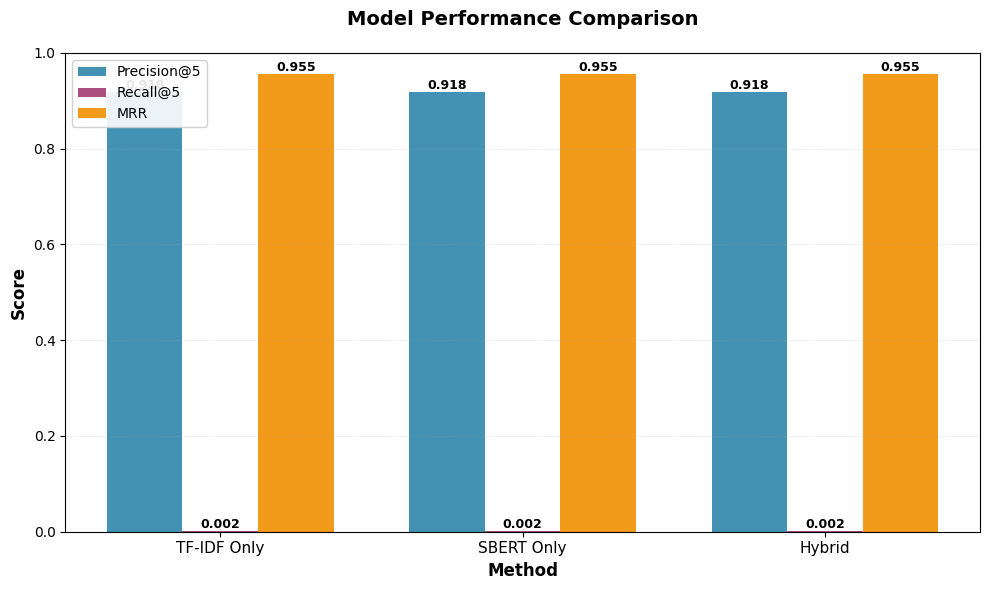

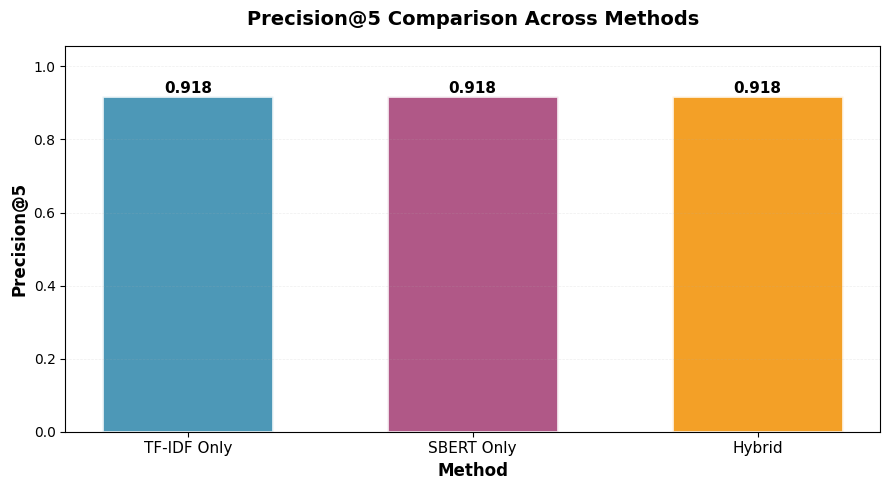

In [48]:
# Create  visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
methods_list = list(comparison.keys())
metrics = ['precision@k', 'recall@k', 'mrr']
x = np.arange(len(methods_list))
width = 0.25

# Colors for each metric
colors = ['#2E86AB', '#A23B72', '#F18F01']  #blue, purple, orange

# Create bars
bars1 = ax.bar(x - width, [comparison[m]['precision@k'] for m in methods_list],
               width, label='Precision@5', color=colors[0], alpha=0.9)
bars2 = ax.bar(x, [comparison[m]['recall@k'] for m in methods_list],
               width, label='Recall@5', color=colors[1], alpha=0.9)
bars3 = ax.bar(x + width, [comparison[m]['mrr'] for m in methods_list],
               width, label='MRR', color=colors[2], alpha=0.9)

# Customize the plot
ax.set_xlabel('Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(methods_list, fontsize=11)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.5)
ax.legend(loc='upper left', fontsize=10, framealpha=0.9)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

# Improve layout
plt.tight_layout()
plt.show()

# Optional: Also create a cleaner single-metric comparison
fig2, ax2 = plt.subplots(figsize=(9, 5))

# Grouped bar chart with better styling
x_pos = np.arange(len(methods_list))
bar_width = 0.6

# Create bars with gradient or solid colors
bars = ax2.bar(x_pos, [comparison[m]['precision@k'] for m in methods_list],
                bar_width, color=['#2E86AB', '#A23B72', '#F18F01'],
                alpha=0.85, edgecolor='white', linewidth=2)

# Customize
ax2.set_xlabel('Method', fontsize=12, fontweight='bold')
ax2.set_ylabel('Precision@5', fontsize=12, fontweight='bold')
ax2.set_title('Precision@5 Comparison Across Methods', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods_list, fontsize=11)
ax2.set_ylim([0, max([comparison[m]['precision@k'] for m in methods_list]) * 1.15])
ax2.grid(True, alpha=0.2, axis='y', linestyle='--', linewidth=0.5)

# Add value labels
for i, (bar, method) in enumerate(zip(bars, methods_list)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# Evaluation
